# NFDI4Objects Knowledge Graph Ogham Sites Visualisation

This notebook fetches Ogham data using a SPARQL query from the N4O KG and creates charts.

## Define SPARQL query service

In [2]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import matplotlib.pyplot as plt

def querySparql(query):
    sparql = SPARQLWrapper("https://graph.nfdi4objects.net/api/sparql")
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    return results['results']['bindings']

## Define the SPARQL Query

In [3]:
# SPARQL Query for Samian Ware Kiln Sites
oghamQuery = """
PREFIX oghamonto: <http://ontology.ogham.link/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT ?county (count(distinct ?stone) as ?count) WHERE {
 ?item <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://ontology.ogham.link/OghamSite> .
 ?item oghamonto:within ?c .
 ?c a oghamonto:County .
 ?c rdfs:label ?county .
 ?stone oghamonto:disclosedAt ?item .
 ?stone a oghamonto:OghamStone_CIIC .
} GROUP BY ?county ORDER BY DESC(?count)
"""

## Fetch Data and Convert to DataFrame

In [4]:
# Fetch data using the SPARQL query
sparql_results = querySparql(oghamQuery)

# Convert SPARQL JSON results into a DataFrame
data = []
for result in sparql_results:
    data.append({
        "county": result.get("county", {}).get("value", None),
        "count": int(result.get("count", {}).get("value", 0))
    })

df = pd.DataFrame(data)
df

,county,count
0,Kerry,127
1,Cork,81
2,Waterford,47
3,Kilkenny,12
4,Kildare,8
5,Mayo,8
6,Wexford,5
7,Wicklow,5
8,Carlow,4
9,Clare,3


## Visualise the Data with Charts

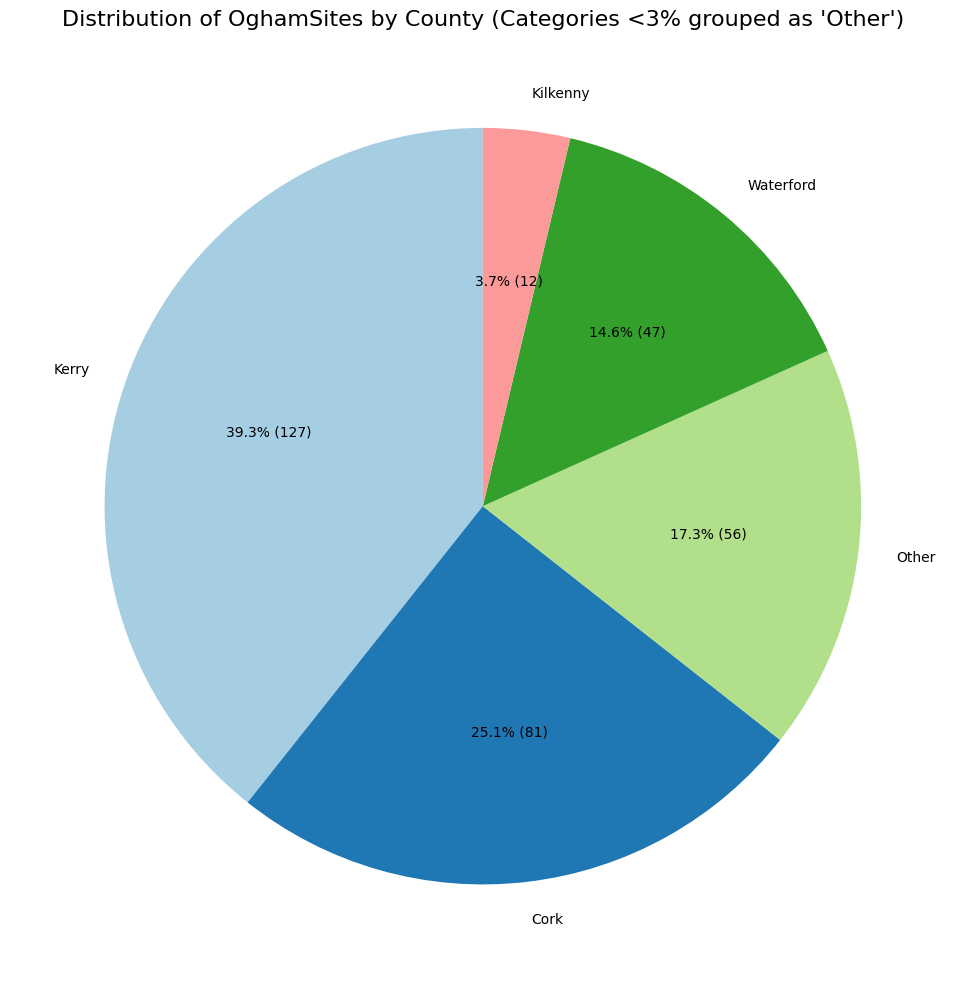

In [5]:
# Calculate the total number of stones.
total_count = df["count"].sum()

# Compute the percentage for each county.
df["percentage"] = df["count"] / total_count * 100

# Separate counties with a percentage >= 3% from those with less than 3%.
major_df = df[df["percentage"] >= 3].copy()
minor_df = df[df["percentage"] < 3].copy()

# If there are counties with less than 3%, combine them into an 'Other' category.
if not minor_df.empty:
    other_count = minor_df["count"].sum()
    major_df = pd.concat([major_df, pd.DataFrame([{"county": "Other", "count": other_count}])], ignore_index=True)

# Optional: Sort the categories by count in descending order.
major_df = major_df.sort_values("count", ascending=False)

# Define a function to format the autopct text to include both the percentage and the stone count.
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return '{:.1f}% ({:d})'.format(pct, count)
    return my_autopct

# Create a pie chart displaying the distribution of OghamSites by county.
plt.figure(figsize=(10, 10))
major_df.set_index("county")["count"].plot(
    kind="pie",
    autopct=make_autopct(major_df["count"]),
    startangle=90,
    colors=plt.cm.Paired.colors
)
plt.title("Distribution of OghamSites by County (Categories <3% grouped as 'Other')", fontsize=16)
plt.ylabel("")  # Remove the default y-label.
plt.tight_layout()
plt.show()

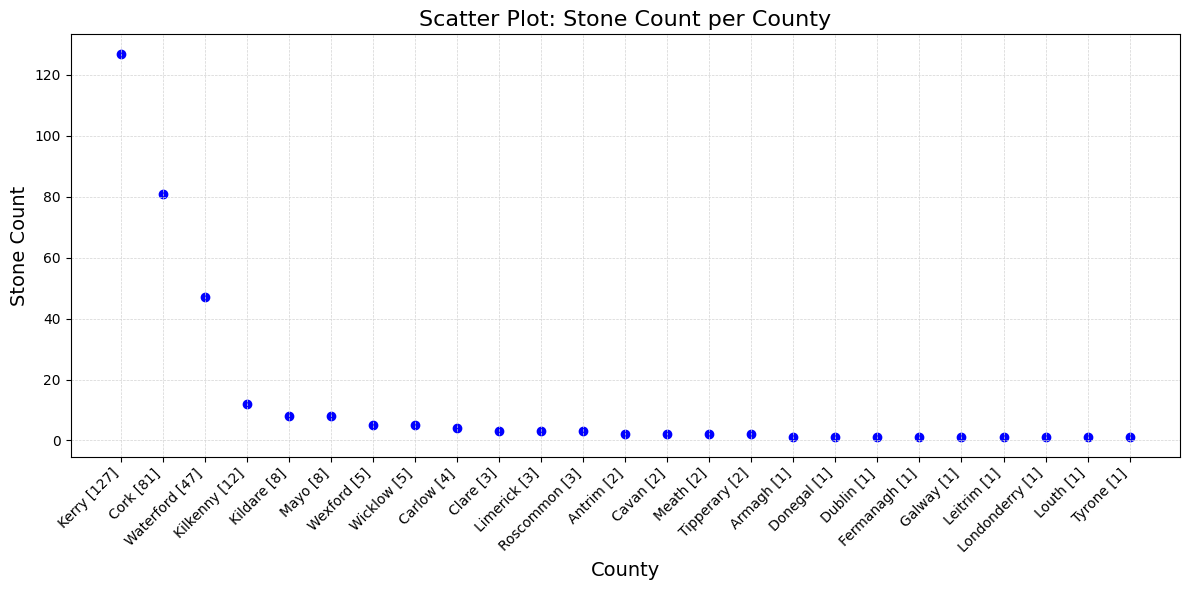

In [6]:
# Create a scatter plot with county on the x-axis and stone count on the y-axis.
plt.figure(figsize=(12, 6))
x_positions = range(len(df))
plt.scatter(x_positions, df["count"], color="blue")
plt.title("Scatter Plot: Stone Count per County", fontsize=16)
plt.xlabel("County", fontsize=14)
plt.ylabel("Stone Count", fontsize=14)

# Create customised x-axis labels with county and count in square brackets.
xtick_labels = [f"{county} [{count}]" for county, count in zip(df["county"], df["count"])]
plt.xticks(x_positions, xtick_labels, rotation=45, ha="right")

# Add a light grey grid.
plt.grid(color="lightgrey", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()